<h1><center>Bayesian Course</center></h1>

<h2>Lecture 15: Robust Regression</h2>

<h3>References</h3>

1. Taken from  <url>https://jrnold.github.io/bayesian_notes/</url>

En este cuaderno vereos como utilizar un comando mágico para poder tener celdas completas con código STAN.

<h2><span class="header-section-number">15.1</span> Wide Tailed Distributions</h2>
Bayesian linear regression with normally distributed errors is sensitive to outliers. This is because the normal distribution has narrow tail probabilities, with approximately 99.8% of the probability within three standard deviations.

Robust regression refers to regression methods which are less sensitive to outliers. Bayesian robust regression uses distributions with wider tails than the normal instead of the normal. This plots the normal, Double Exponential (Laplace), and Student-t $( df = 4)$ distributions all with mean 0 and scale 1, and the **surprise** $(−\log p)$  at each point. 


Both the Student- t   and Double Exponential distributions have surprise values well below the normal in the ranges (-6, 6). This means that outliers will have less of an affect on the log-posterior of models using these distributions. The regression line would need to move less incorporate those observations since the error distribution will not consider them as unusual.

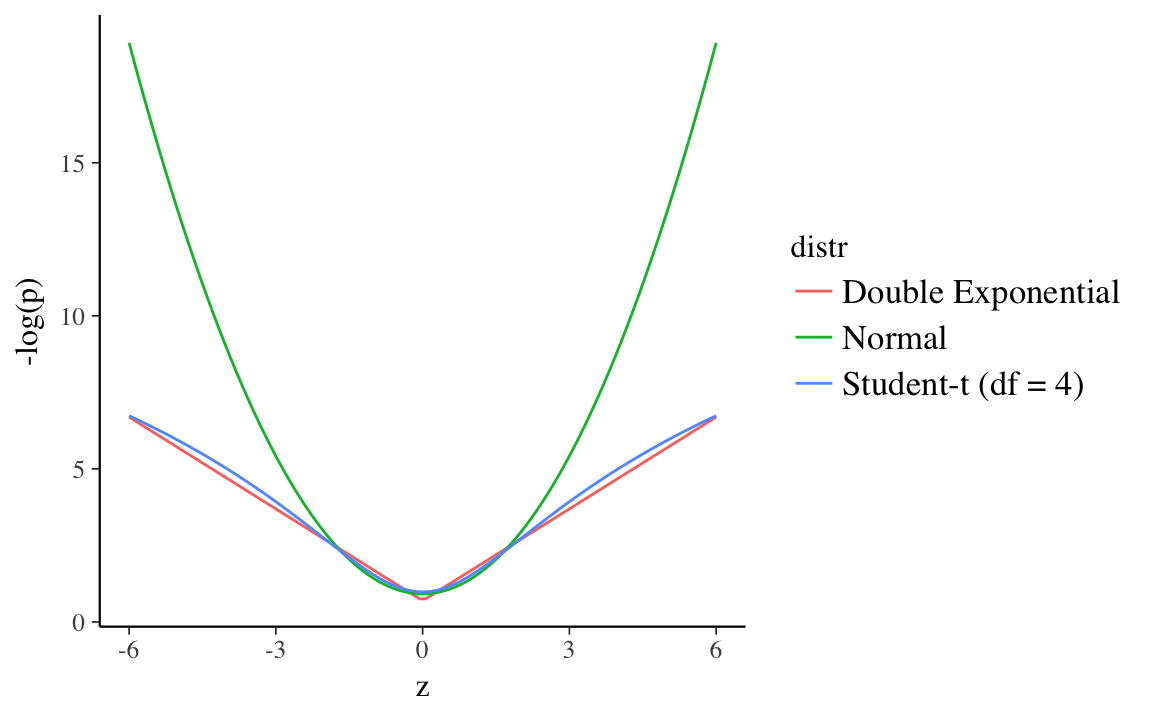

In [1]:
from IPython.display import Image
Image(filename="D:/home/Bayesian_Course/images/minus_log_Normal_t_doble_exp.png")

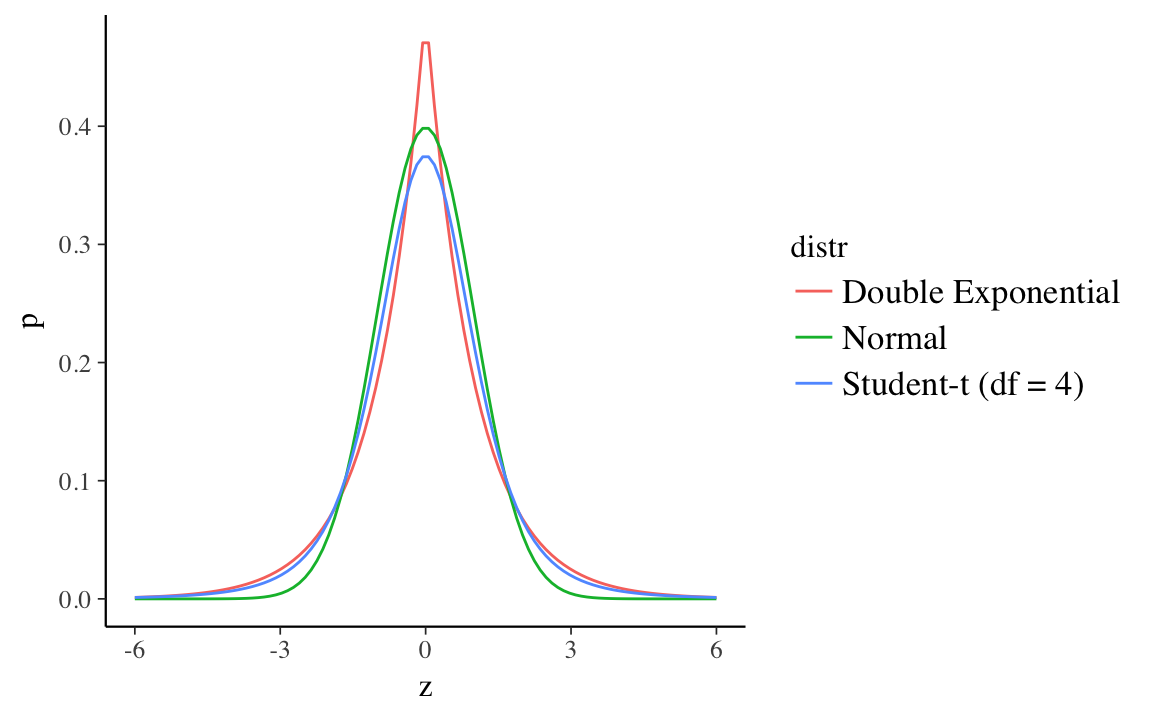

In [2]:
from IPython.display import Image
Image(filename="D:/home/Bayesian_Course/images/density_log_Normal_t_doble_exp.png")

<h2><span class="header-section-number">15.2</span> Student-t distribution</h2>
<p>The most commonly used Bayesian model for robust regression is a linear regression with independent Student-$t$ errors (Geweke 1993; A. Gelman, Carlin, et al. 2013, Ch. 17)
    
    
$$
y_i \sim Student T\left(\nu, \mu_i, \sigma \right)
$$
    
$\nu \in \mathcal{R}^{+}$ is a degrees of freedom parameter, $\mu_i \in \mathcal{R}$ are observation specific locations often modeled with a regression, and and $\sigma \in \mathcal{R}^{+}$ is a the scale parameter. The pdf of the Student-$t distribution is given by
    
$$
Student T\left(x;\nu, \mu, \sigma \right) = K \left( 1 + \frac{1}{\nu} \left(\frac{x-\mu}{\sigma}\right)^2   \right)^{-\frac{\nu+1}{2}},
$$
where $K$ is a normalizing constant.    

    
Note that as $\nu \to \infty$, this model approaches an independent normal model, since the Student-t distribution asymptotically approaches the normal distribution as the degrees of freedom increases. For the value of $\nu$, either a low degrees of freedom, say $\nu \in (4, 6)$ can be used, or it can be given a prior distribution.


For the Student-t distribution, the existence of various moments depends on the value of $\nu$: the mean exists for $\nu\ge 1$ variance for $\nu\ge 2$, and kurtosis for $\nu\ge 3$.

As such, it is often useful to restrict the support of $\nu$  to at least 1 or 2 (or even higher) ensure the existence of a mean or variance.

A reasonable prior distribution for the degrees of freedom parameter is a Gamma
distribution with shape parameter 2, and an inverse-scale (rate) parameter of 0.1 (Juárez and Steel 2010, @Stan-prior-choices), $\nu \sim Gamma(2, 0.1)$.

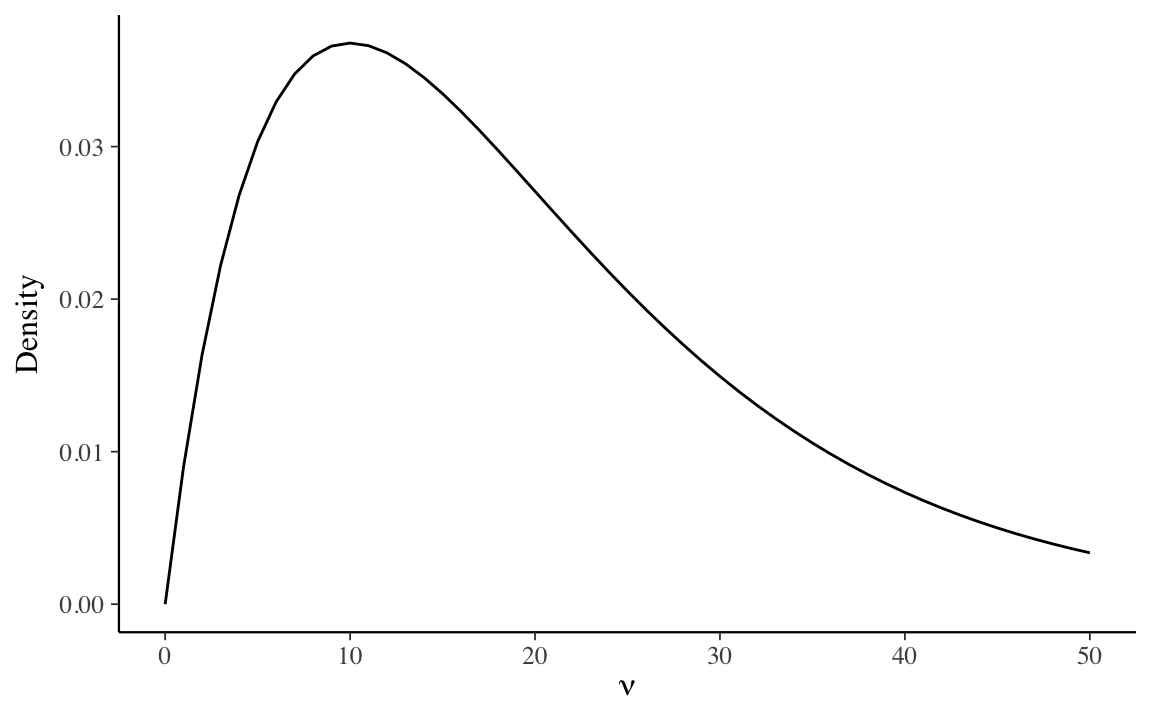

In [4]:
from IPython.display import Image
Image(filename="D:/home/Bayesian_Course/images/gamma_2_01_distribution.png")

This density places the majority of the prior mass for values $\nu \le 50$, in which
the Student-t distribution is substantively different from the Normal distribution,
and also allows for all prior moments to exist.

<h3> Data </h3>

Some authors have debated whether the political and economic of the Left has had a sustained impact on the economic growth of relative affluent capitalist democracies since 1973. Data is about growth of some countries betwwen 1978 and 1982. The author claims that the accelerate growth is due to both unions were organizationally strong and Left parties were strong participants in goverments.


In [13]:
import pandas as pd
import numpy as np
path = "D:/home/Bayesian_Course/Data/"
econ_growth = pd.read_csv(path +"econ_growth.csv")

In [14]:
econ_growth.head()

,country,econ_growth,labor_org,social_dem
0,Australia,0.51,1.87,30.5
1,Austria,0.64,3.06,100.0
2,Belgium,0.44,2.80,21.0
3,Canada,0.50,0.98,0.0
4,Denmark,0.36,2.77,75.5


In [15]:
econ_growth.describe()

,econ_growth,labor_org,social_dem
count,15.000000,15.000000,15.000000
mean,0.514667,2.000000,41.553333
std,0.175616,1.001335,37.443078
min,0.260000,0.430000,0.000000
25%,0.440000,1.225000,4.100000
50%,0.510000,1.870000,40.200000
75%,0.545000,2.785000,75.150000
max,1.050000,3.520000,100.000000


In [43]:
# add a new column to the data frame. cross effect labor_org*social_dem
econ_growth['labor_soc_dem'] = econ_growth.labor_org * econ_growth.social_dem
econ_growth.head()

,country,econ_growth,labor_org,social_dem,labor_soc_dem
0,Australia,0.51,1.87,30.5,57.035
1,Austria,0.64,3.06,100.0,306.000
2,Belgium,0.44,2.80,21.0,58.800
3,Canada,0.50,0.98,0.0,0.000
4,Denmark,0.36,2.77,75.5,209.135


In [64]:
# normalizing the columns of data
# install sklearn
# pip install sklearn
from sklearn.preprocessing import StandardScaler as SS

econ_growth['growth_ss'] = SS().fit_transform(econ_growth[['econ_growth']])
econ_growth['labor_ss'] = SS().fit_transform(econ_growth[['labor_org']])
econ_growth['soc_dem_ss'] = SS().fit_transform(econ_growth[['social_dem']])
econ_growth['labor_soc_dem_ss'] = SS().fit_transform(econ_growth[['labor_soc_dem']])
econ_growth.head()

,country,econ_growth,labor_org,social_dem,labor_soc_dem,growth_ss,labor_ss,labor_soc_dem_ss,soc_dem_ss
0,Australia,0.51,1.87,30.5,57.035,-0.027506,-0.134383,-0.479036,-0.305565
1,Austria,0.64,3.06,100.0,306.000,0.738728,1.095742,1.874051,1.615734
2,Belgium,0.44,2.80,21.0,58.800,-0.440093,0.826975,-0.462354,-0.568188
3,Canada,0.50,0.98,0.0,0.000,-0.086447,-1.054393,-1.018101,-1.148725
4,Denmark,0.36,2.77,75.5,209.135,-0.911621,0.795963,0.958534,0.938441


## Instalando el comando mágico de pystan

Este comando permite escribir código Stan directamente en una celda. Lo primero que hay que hace es  instalar el comando. En la siguiente código se muestra una forma de hacer la instalación.

Para detalles vea el sitio [stan-magic]( https://github.com/Arvinds-ds/stanmagic/blob/master/StanMagic-Help.ipynb)

In [1]:
import pystan
%load_ext stanmagic

In [17]:
%%stan -f Robust_reg.stan
// Linear Model with Student-t Errors
data {
  // number of observations
  int N;
  // response
  vector[N] y;
  // number of columns in the design matrix X
  int K;
  // design matrix X
  // should not include an intercept
  matrix [N, K] X;
  // priors on alpha
  real scale_alpha;
  vector[K] scale_beta;
  real loc_sigma;
  // keep responses
  int use_y_rep;
  int use_log_lik;
}
parameters {
  // regression coefficient vector
  real alpha;
  vector[K] beta;
  real sigma;
  // degrees of freedom;
  // limit df = 2 so that there is a finite variance
  real nu;
}
transformed parameters {
  vector[N] mu;

  mu = alpha + X * beta;
}
model {
  // priors
  alpha ~ normal(0.0, scale_alpha);
  beta ~ normal(0.0, scale_beta);
  sigma ~ exponential(loc_sigma);
  // see Stan prior distribution suggestions
  nu ~ gamma(2, 0.1);
  // likelihood
  y ~ student_t(nu, mu, sigma);
}
generated quantities {
  // simulate data from the posterior
  vector[N * use_y_rep] y_rep;
  // log-likelihood posterior
  vector[N * use_log_lik] log_lik;
  for (i in 1:num_elements(y_rep)) {
    y_rep[i] = student_t_rng(nu, mu[i], sigma);
  }
  for (i in 1:num_elements(log_lik)) {
    log_lik[i] = student_t_lpdf(y[i] | nu, mu[i], sigma);
  }
}

Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in _stan_model object.
Type _stan_model in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^
Access model compile output properties
_stan_model.model_file -> Name of stan_file [Robust_reg.stan]
_stan_model.model_name -> Name of stan model [Robust_reg_model]
_stan_model.model_code -> Model code [// Linear Model with ....]


In [19]:
_stan_model

model_file: Robust_reg.stan
model_name: Robust_reg_model
model_code:
// Linear Model with Student-t Errors
data {
  // number of observations
  int N;
  // response
  vector[N] y;
  // number of columns in the design matrix X
  int K;
  // design matrix X
  // should not include an intercept
  matrix [N, K] X;
  // priors on alpha
  real scale_alpha;
  vector[K] scale_beta;
  real loc_sigma;
  // keep responses
  int use_y_rep;
  int use_log_lik;
}
parameters {
  // regression coefficient vector
  real alpha;
  vector[K] beta;
  real sigma;
  // degrees of freedom;
  // limit df = 2 so that there is a finite variance
  real nu;
}
transformed parameters {
  vector[N] mu;

  mu = alpha + X * beta;
}
model {
  // priors
  alpha ~ normal(0.0, scale_alpha);
  beta ~ normal(0.0, scale_beta);
  sigma ~ exponential(loc_sigma);
  // see Stan prior distribution suggestions
  nu ~ gamma(2, 0.1);
  // likelihood
  y ~ student_t(nu, mu, sigma);
}
generated quantities {
  // simulate data from the posterior
  vector[N * use_y_rep] y_rep;
  // log-likelihood posterior
  vector[N * use_log_lik] log_lik;
  for (i in 1:num_elements(y_rep)) {
    y_rep[i] = student_t_rng(nu, mu[i], sigma);
  }
  for (i in 1:num_elements(log_lik)) {
    log_lik[i] = student_t_lpdf(y[i] | nu, mu[i], sigma);
  }
}

In [105]:
from collections import OrderedDict
#data = OrderedDict({'X':X, 'y': y, 'N':N, 'K': K})

import numpy as np
#X= np.array(econ_growth[['labor_ss', 'soc_dem_ss','labor_soc_dem_ss']])
#y= np.array(econ_growth[['growth_ss']])
data = OrderedDict({'N':15, 'K':3, 'scale_alpha': 10, 'scale_beta': [2.5, 2.5, 2.5], 
                    'loc_sigma':  1, 'use_y_rep': 1, 'use_log_lik': 1, 'd': 4,
                    'X':np.array(econ_growth[['labor_ss', 'soc_dem_ss','labor_soc_dem_ss']]), 
                    'y': np.reshape(np.array(econ_growth[['growth_ss']]),15,0)})


In [65]:
econ_growth

,country,econ_growth,labor_org,social_dem,labor_soc_dem,growth_ss,labor_ss,labor_soc_dem_ss,soc_dem_ss
0,Australia,0.51,1.87,30.5,57.035,-0.027506,-0.134383,-0.479036,-0.305565
1,Austria,0.64,3.06,100.0,306.000,0.738728,1.095742,1.874051,1.615734
2,Belgium,0.44,2.80,21.0,58.800,-0.440093,0.826975,-0.462354,-0.568188
3,Canada,0.50,0.98,0.0,0.000,-0.086447,-1.054393,-1.018101,-1.148725
4,Denmark,0.36,2.77,75.5,209.135,-0.911621,0.795963,0.958534,0.938441
5,Finland,0.56,2.76,40.2,110.952,0.267199,0.785626,0.030559,-0.037412
6,France,0.57,0.68,1.7,1.156,0.326140,-1.364508,-1.007175,-1.101729
7,Germany,0.53,1.80,74.8,134.640,0.090376,-0.206744,0.254446,0.919090
8,Holland,0.44,1.90,41.2,78.280,-0.440093,-0.103372,-0.278240,-0.009768
9,Italy,0.53,1.47,6.5,9.555,0.090376,-0.547871,-0.927792,-0.969035


In [106]:
data

OrderedDict([('N', 15),
             ('K', 3),
             ('scale_alpha', 10),
             ('scale_beta', [2.5, 2.5, 2.5]),
             ('loc_sigma', 1),
             ('use_y_rep', 1),
             ('use_log_lik', 1),
             ('d', 4),
             ('X', array([[-0.13438341, -0.30556481, -0.47903615],
                     [ 1.09574162,  1.61573382,  1.87405088],
                     [ 0.82697481, -0.56818836, -0.4623543 ],
                     [-1.05439288, -1.14872464, -1.01810116],
                     [ 0.79596325,  0.9384415 ,  0.95853354],
                     [ 0.78562607, -0.03741234,  0.03055915],
                     [-1.36450843, -1.10172884, -1.00717525],
                     [-0.2067437 ,  0.91909029,  0.25444574],
                     [-0.10337185, -0.00976775, -0.27823952],
                     [-0.54787081, -0.96903484, -0.92779229],
                     [-1.62293806, -1.14872464, -1.01810116],
                     [ 1.37484561,  1.61573382,  2.12924077],
      

In [73]:
robust_reg_model = pystan.StanModel(file=_stan_model.model_file)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e831b8b29fafba661ed597597b7e23bd NOW.


In [107]:
robust_reg_sample = robust_reg_model.sampling(data=data)

In [108]:
robust_reg_sample

Inference for Stan model: anon_model_e831b8b29fafba661ed597597b7e23bd.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha        -0.03  8.2e-3   0.24  -0.51  -0.18  -0.03   0.13   0.44    871   1.01
beta[1]      -0.25    0.01    0.4  -1.03  -0.51  -0.26 2.7e-3   0.55    806    1.0
beta[2]      -1.11    0.05   0.78  -2.54  -1.64  -1.15  -0.63   0.41    250   1.01
beta[3]       1.63    0.08   0.99  -0.78   1.06   1.71   2.29   3.42    152   1.02
sigma          0.8    0.01   0.22   0.36   0.65   0.77   0.92    1.3    241   1.03
nu           18.11    0.57  13.43   1.05   8.06  15.13  25.06  52.54    547   1.01
mu[1]        -0.44    0.01    0.3  -1.02  -0.63  -0.44  -0.24   0.14    712    1.0
mu[2]         0.95    0.06   0.71  -0.83   0.58    1.0   1.41   2.17    135   1.03
mu[3]        -0.36    0.01    0.5  -1.39  -0.67  -0.36  -0.04   